In [ ]:
%load_ext autoreload
%autoreload 2

import qubx
%qubxd

import time
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any
from pathlib import Path
from IPython.display import clear_output
from collections import defaultdict

import os
import dotenv
from qubx import QubxLogConfig
from qubx.utils.runner import run_ccxt_trading

from qubx import lookup, logger, QubxLogConfig
from qubx.core.basics import TriggerEvent, Trade, MarketEvent, Instrument, Subtype, FundingRate
from qubx.core.interfaces import IStrategyContext, IStrategy
from qubx.connectors.ccxt.ccxt_connector import CCXTExchangesConnector
from qubx.connectors.ccxt.ccxt_trading import CCXTTradingConnector
from qubx.utils.runner import get_account_config
from qubx.pandaz import scols
from qubx.backtester.simulator import SimulatedTrading
from qubx.utils.runner import run_ccxt_paper_trading
from qubx.utils.collections import TimeLimitedDeque


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. 0.4.0
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


## 1.0 Live paper trading

In [ ]:
class TradeTestStrat(IStrategy):
    _data_counter: int = 0
    _data_to_buffer: dict[tuple[str, Instrument], TimeLimitedDeque]

    def on_init(self, ctx: IStrategyContext):
        # ctx.set_base_subscription(Subtype.ORDERBOOK)
        ctx.set_base_subscription(Subtype.OHLC)
        ctx.set_warmup(Subtype.OHLC, "1h")
        # ctx.set_base_subscription(Subtype.TRADE)
        self._data_to_buffer = defaultdict(lambda: TimeLimitedDeque("1Min", lambda x: x.time, unit="ns"))
    
    def on_start(self, ctx: IStrategyContext):
        ctx.subscribe(ctx.instruments, Subtype.FUNDING_RATE)

    def on_market_data(self, ctx: IStrategyContext, event: MarketEvent):
        if event.type == Subtype.LIQUIDATION:
            logger.debug(f"[{event.instrument}] Received liquidation: {event.data}")

        self._data_counter += 1

        if event.instrument:
            self._data_to_buffer[(event.type, event.instrument)].append(event.data)
        elif isinstance(event.data, dict):
            for instrument, data in event.data.items():
                self._data_to_buffer[(event.type, instrument)].append(data)

        if self._data_counter % 1000 == 0:
            logger.debug(f"Processed {self._data_counter} data points")

    def on_universe_change(
        self, ctx: IStrategyContext, add_instruments: list[Instrument], rm_instruments: list[Instrument]
    ):
        if add_instruments:
            _sub_to_params = ctx.get_subscriptions(ctx.instruments[0])
            for sub, params in _sub_to_params.items():
                ctx.subscribe(add_instruments, sub, **params)

    def get_data(self, instrument: Instrument, type: str) -> list:
        return list(self._data_to_buffer[(type, instrument)])
    
    def get_funding_rates(self) -> pd.DataFrame:
        funding_rates = {
            instr: data.__dict__ for (d_type, instr), data in self._data_to_buffer.items() if d_type == Subtype.FUNDING_RATE
        }
        return pd.DataFrame(funding_rates).T



ctx = run_ccxt_paper_trading(
    strategy=(stg := TradeTestStrat()),
    exchange="BINANCE.UM",
    symbols=["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT"],
    blocking=False,
)

2024-11-18 13:13:15.374 [🐞] NTP offset controller thread is started


2024-11-18 13:13:15.374 [ℹ️] binance.um initialized - current time 2024-11-18T13:13:15.374831
2024-11-18 13:13:15.374 [ℹ️] (StrategyContext) Start processing market data
2024-11-18 13:13:15.374 [ℹ️] (StrategyContext) strategy is started in thread


2024-11-18 13:13:15.374 [🐞] Running OHLC warmup for {BINANCE.UM:CRYPTO:XRPUSDT, BINANCE.UM:CRYPTO:ADAUSDT, BINANCE.UM:CRYPTO:ETHUSDT, BINANCE.UM:CRYPTO:BTCUSDT} with period 1h
2024-11-18 13:13:15.374 [ℹ️] BINANCE.UM:CRYPTO:XRPUSDT: loaded 60 1m bars
2024-11-18 13:13:15.374 [🐞] Invoking TradeTestStrat on_fit
2024-11-18 13:13:15.374 [🐞] TradeTestStrat is fitted
2024-11-18 13:13:15.374 [🐞] Listening to funding_rate
2024-11-18 13:13:15.374 [ℹ️] BINANCE.UM:CRYPTO:ADAUSDT: loaded 60 1m bars
2024-11-18 13:13:15.374 [ℹ️] BINANCE.UM:CRYPTO:ETHUSDT: loaded 60 1m bars
2024-11-18 13:13:15.374 [ℹ️] BINANCE.UM:CRYPTO:BTCUSDT: loaded 60 1m bars
2024-11-18 13:13:15.374 [🐞] Listening to XRPUSDT,ADAUSDT,ETHUSDT,BTCUSDT ohlc (warmup_period=1h)
2024-11-18 13:14:40.457 [🐞] Processed 1000 data points
2024-11-18 13:16:01.109 [🐞] Processed 2000 data points
2024-11-18 13:17:21.014 [🐞] Processed 3000 data points
2024-11-18 13:18:40.789 [🐞] Processed 4000 data points
2024-11-18 13:20:06.368 [🐞] Processed 5000 da

In [3]:
# ctx.subscribe(ctx.instruments, Subtype.LIQUIDATION)
ctx.subscribe(ctx.instruments, Subtype.FUNDING_RATE)

In [28]:
ctx.stop()

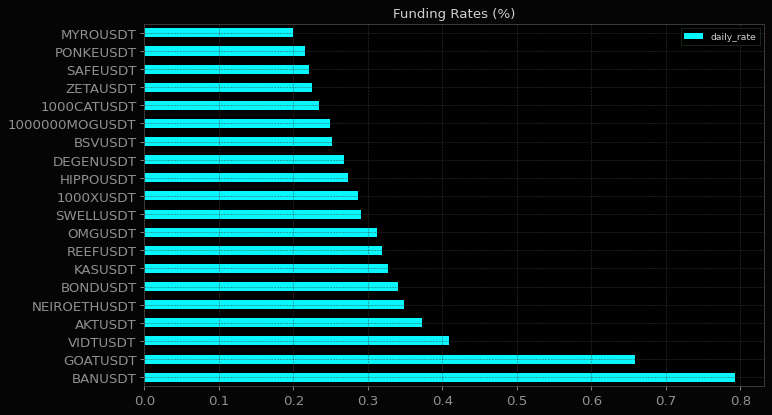

In [ ]:


def get_funding_rates(stg) -> pd.DataFrame:
    funding_rates = {
        instr.symbol: {
            "rate": data[-1].rate,
            "next_funding_time": data[-1].next_funding_time,
            "interval": data[-1].interval,
        }
        for (d_type, instr), data in stg._data_to_buffer.items()
        if d_type == Subtype.FUNDING_RATE and isinstance(data[-1], FundingRate)
    }
    return pd.DataFrame(funding_rates).T


fr = get_funding_rates(stg)
fr["daily_rate"] = fr["rate"] / fr["interval"].apply(lambda x: pd.Timedelta(x).total_seconds() / 3600) * 24 * 100
fr.sort_values("daily_rate", ascending=False).head(20).plot.barh(y="daily_rate", title="Funding Rates (%)", figsize=(10, 6));

In [4]:
stg.get_data(ctx.instruments[-1], Subtype.FUNDING_RATE)

[FundingRate(time=numpy.datetime64('2024-11-18T13:13:18.000'), rate=0.00044787, interval='8h', next_funding_time=numpy.datetime64('2024-11-18T16:00:00.000'), mark_price=1.11057586, index_price=1.10967541),
 FundingRate(time=numpy.datetime64('2024-11-18T13:13:19.000'), rate=0.00044787, interval='8h', next_funding_time=numpy.datetime64('2024-11-18T16:00:00.000'), mark_price=1.11057586, index_price=1.10967541),
 FundingRate(time=numpy.datetime64('2024-11-18T13:13:20.000'), rate=0.00044787, interval='8h', next_funding_time=numpy.datetime64('2024-11-18T16:00:00.000'), mark_price=1.11056877, index_price=1.10966833),
 FundingRate(time=numpy.datetime64('2024-11-18T13:13:21.000'), rate=0.00044787, interval='8h', next_funding_time=numpy.datetime64('2024-11-18T16:00:00.000'), mark_price=1.1102122, index_price=1.10931176),
 FundingRate(time=numpy.datetime64('2024-11-18T13:13:22.001'), rate=0.00044787, interval='8h', next_funding_time=numpy.datetime64('2024-11-18T16:00:00.000'), mark_price=1.110352

In [ ]:
len(ctx.get_data(ctx.instruments[0], Subtype.TRADE))

In [ ]:
i1 = ctx.instruments[1]
obs = stg.get_data("ohlc", i1)
print(f"Instrument: {i1}")
for i in range(1, 5):
    print(obs[-i])

### Add trade subscription and remove it

In [ ]:
ctx.subscribe(ctx.instruments, Subtype.TRADE)

In [ ]:
trades = stg.get_data("trade", ctx.instruments[0])
trades[-5:]

In [ ]:
stg.ctx.unsubscribe(ctx.instruments, Subtype.TRADE)

### Add new instrument to the universe

In [ ]:
s1 = lookup.find_symbol("BINANCE.UM", "XRPUSDT"); assert s1 is not None
ctx.set_universe(list(set(ctx.instruments) | {s1}))

In [ ]:
new_instruments = ctx.instruments[-2:]
print(new_instruments)
ctx.set_universe(new_instruments)

In [ ]:
obs = stg.get_data("orderbook", s1)
obs[-1]

In [ ]:
s2 = lookup.find_symbol("BINANCE.UM", "ADAUSDT"); assert s2 is not None
stg.ctx.set_universe(list(set(stg.ctx.instruments) | {s2}))

In [ ]:
trades = stg.get_data("trade", s2)
trades[-5:]

In [ ]:
ctx.stop()

## 2.0 Live execution

In [ ]:
QubxLogConfig.set_log_level("DEBUG")


class TradeTestStrat(IStrategy):
    _data_counter: int = 0

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(Subtype.OHLC, timeframe="1m")
        ctx.set_warmup(Subtype.OHLC, "1h")
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        self._data_counter += 1
        if self._data_counter % 1000 == 0:
            logger.debug(f"Processed {self._data_counter} data points")

    def on_universe_change(
        self, ctx: IStrategyContext, add_instruments: list[Instrument], rm_instruments: list[Instrument]
    ):
        if add_instruments:
            _sub_to_params = ctx.get_subscriptions(ctx.instruments[0])
            for sub, params in _sub_to_params.items():
                ctx.subscribe(add_instruments, sub, **params)


dotenv.load_dotenv(
    "/mnt/HC_Volume_100695026/home/shared/devs/Qubx/debug/.env.binance.yuriy"
)

credentials = {
    "apiKey": os.getenv("BINANCE_KEY"),
    "secret": os.getenv("BINANCE_SECRET")
}

ctx = run_ccxt_trading(
    strategy=(stg := TradeTestStrat()),
    exchange="BINANCE",
    symbols=["BTCUSDT", "ETHUSDT"],
    credentials=credentials,
    blocking=False,
)

2024-11-15 09:41:25.487 [ ℹ️ ] BINANCE loading ...
2024-11-15 09:41:28.763 [ 🐞 ] NTP offset controller thread is started
2024-11-15 09:41:28.790 [ ℹ️ ] binance initialized - current time 2024-11-15T09:41:28.774249728
2024-11-15 09:41:28.790 [ ℹ️ ] Loading account data for Binance
2024-11-15 09:41:29.517 [ ⚠️ ] qubx.connectors.ccxt.ccxt_utils:ccxt_restore_position_from_deals:102 - Couldn't restore full deals history for BTCUSDT symbol. Qubx will use zero position !
2024-11-15 09:41:30.007 [ ⚠️ ] qubx.connectors.ccxt.ccxt_utils:ccxt_restore_position_from_deals:102 - Couldn't restore full deals history for ETHUSDT symbol. Qubx will use zero position !
2024-11-15 09:41:30.010 [ 🐞 ] Running OHLC warmup for {BINANCE:CRYPTO:BTCUSDT, BINANCE:CRYPTO:ETHUSDT} with period 1h
2024-11-15 09:41:30.010 [ 🐞 ] Listening to BTCUSDT executions
2024-11-15 09:41:30.011 [ 🐞 ] Listening to ETHUSDT executions
2024-11-15 09:41:30.012 [ ℹ️ ] (StrategyContext) Start processing market data
2024-11-15 09:41:30.013

2024-11-15 09:41:32.280 [ ℹ️ ] BINANCE:CRYPTO:BTCUSDT: loaded 60 1m bars
2024-11-15 09:41:32.281 [ 🐞 ] Invoking TradeTestStrat on_fit
2024-11-15 09:41:32.282 [ 🐞 ] TradeTestStrat is fitted
2024-11-15 09:41:32.312 [ ℹ️ ] BINANCE:CRYPTO:ETHUSDT: loaded 60 1m bars
2024-11-15 09:41:32.313 [ 🐞 ] Listening to BTCUSDT,ETHUSDT ohlc (warmup_period=1h)
2024-11-15 09:41:36.462 [ 🐞 ] New instruments for trade warmup: {BINANCE:CRYPTO:BTCUSDT, BINANCE:CRYPTO:ETHUSDT}
2024-11-15 09:41:36.729 [ 🐞 ] Loaded 500 trades for BINANCE:CRYPTO:BTCUSDT
2024-11-15 09:41:36.749 [ 🐞 ] Loaded 500 trades for BINANCE:CRYPTO:ETHUSDT
2024-11-15 09:41:36.749 [ 🐞 ] Listening to BTCUSDT,ETHUSDT trade (warmup_period=1m)
2024-11-15 09:41:43.701 [ 🐞 ] Processed 1000 data points
2024-11-15 09:41:45.650 [ 🐞 ] Processed 2000 data points
2024-11-15 09:41:49.860 [ 🐞 ] Processed 3000 data points
2024-11-15 09:41:50.080 [ 🐞 ] Canceling existing trade subscription for {BINANCE:CRYPTO:BTCUSDT, BINANCE:CRYPTO:ETHUSDT}
2024-11-15 09:42

In [24]:
ctx.get_total_capital()

17.05809094

In [26]:
ctx.ohlc(ctx.instruments[0]).pd().tail()

,open,high,low,close,volume,bought_volume
timestamp,,,,,,
2024-11-15 09:34:00,89102.38,89179.79,89076.00,89179.79,2.643599e+06,1.058410e+06
2024-11-15 09:35:00,89179.79,89350.00,89173.29,89332.25,4.888036e+06,2.760296e+06
2024-11-15 09:36:00,89332.50,89336.39,89160.00,89227.30,2.649142e+06,1.016469e+06
2024-11-15 09:37:00,89227.29,89320.00,89227.29,89243.82,1.845508e+06,8.808934e+05
2024-11-15 09:38:00,89243.83,89312.00,89240.00,89240.00,1.316401e+06,3.701344e+05


In [15]:
o = ctx.trade(ctx.instruments[0], amount=0.00019, price=88000)
o

Order(id='32397996623', type='LIMIT', instrument=BINANCE:CRYPTO:BTCUSDT, time=Timestamp('2024-11-13 18:29:01.332000'), quantity=0.00019, price=88000.0, side='BUY', status='NEW', time_in_force='GTC', client_id='TradeTestStrat_BTCUSDT_17315225413', cost=0.0, options={})

In [16]:
ctx.cancel_order(o.id)

In [6]:
ctx.subscribe(ctx.instruments, Subtype.TRADE)

In [7]:
ctx.unsubscribe(ctx.instruments, Subtype.TRADE)

In [ ]:
ctx.get_data(ctx.instruments[0], Subtype.TRADE)[-5:]

In [ ]:
ctx.set_universe([ctx.instruments[0]])

In [18]:
ctx.subscribe(ctx.instruments, Subtype.ORDERBOOK)

In [ ]:
ctx.unsubscribe(ctx.instruments, Subtype.ORDERBOOK)

In [22]:
ctx.get_data(ctx.instruments[0], Subtype.TRADE)[-5:]

[[2024-11-13T18:30:34.078000000]	92689.37000 (0.00) take 4066180607,
 [2024-11-13T18:30:34.078000000]	92689.37000 (0.00) take 4066180608,
 [2024-11-13T18:30:34.078000000]	92689.37000 (0.00) take 4066180609,
 [2024-11-13T18:30:34.078000000]	92689.37000 (0.00) take 4066180610,
 [2024-11-13T18:30:34.078000000]	92689.37000 (0.00) take 4066180611]

In [23]:
ctx.get_data(ctx.instruments[0], Subtype.ORDERBOOK)[-5:]

[[2024-11-13T18:30:43.213000000] 92687.4 (5.00577) | 92687.41 (2.88649),
 [2024-11-13T18:30:43.313000000] 92687.4 (5.36551) | 92687.41 (0.74832),
 [2024-11-13T18:30:43.413000000] 92687.4 (4.57564) | 92687.41 (0.41051),
 [2024-11-13T18:30:43.513000000] 92687.4 (4.58619) | 92687.41 (0.55437),
 [2024-11-13T18:30:43.613000000] 92687.4 (4.58658) | 92687.41 (0.55437)]

In [25]:
i1 = ctx.instruments[0]
q = ctx.quote(i1)
q

[2024-11-13T18:31:11.513000000]	92536.88000 (1.6) | 92536.89000 (2.6)

In [8]:
ctx.stop()

In [ ]:
pd.Timedelta("1h").seconds

## Tmp stuff

In [2]:
class TradeTestStrat(IStrategy):
    _data_counter: int = 0

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(Subtype.OHLC, timeframe="1m")
        ctx.set_warmup(Subtype.OHLC, "1h")
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        self._data_counter += 1
        if self._data_counter % 1000 == 0:
            logger.debug(f"Processed {self._data_counter} data points")

    def on_universe_change(
        self, ctx: IStrategyContext, add_instruments: list[Instrument], rm_instruments: list[Instrument]
    ):
        if add_instruments:
            _sub_to_params = ctx.get_subscriptions(ctx.instruments[0])
            for sub, params in _sub_to_params.items():
                ctx.subscribe(add_instruments, sub, **params)


options = dotenv.dotenv_values("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/.env.integration")

test_credentials = {
    "BINANCE": {
        "apiKey": options["BINANCE_SPOT_API_KEY"],
        "secret": options["BINANCE_SPOT_SECRET"]
    },
    "BINANCE.UM": {
        "apiKey": options["BINANCE_FUTURES_API_KEY"],
        "secret": options["BINANCE_FUTURES_SECRET"]
    }
}

exchange = "BINANCE.UM"

ctx = run_ccxt_trading(
    strategy=(stg := TradeTestStrat()),
    exchange=exchange,
    symbols=["BTCUSDT"],
    credentials=test_credentials[exchange],
    blocking=False,
    use_testnet=True,
    commissions="vip0_usdt",
)

i1 = ctx.instruments[0]

2024-11-17 12:49:52.256 [ ℹ️ ] (ccxt_trading) BINANCEUSDM loading ...
2024-11-17 12:49:52.858 [ 🐞 ] (ntp) NTP offset controller thread is started
2024-11-17 12:49:52.888 [ ℹ️ ] (ccxt_connector) binance.um initialized - current time 2024-11-17T12:49:52.867604992
2024-11-17 12:49:52.889 [ ℹ️ ] (ccxt_trading) Loading account data for Binance USDⓈ-M
2024-11-17 12:49:54.099 [ 🐞 ] (ccxt_connector) Running OHLC warmup for {BINANCE.UM:CRYPTO:BTCUSDT} with period 1h
2024-11-17 12:49:54.100 [ 🐞 ] (ccxt_connector) Listening to BTCUSDT executions
2024-11-17 12:49:54.100 [ ℹ️ ] (ccxt_connector) Channel BTCUSDT executions is set to True
2024-11-17 12:49:54.101 [ ℹ️ ] (context) (StrategyContext) Start processing market data
2024-11-17 12:49:54.101 [ ℹ️ ] (context) (StrategyContext) strategy is started in thread
2024-11-17 12:49:55.012 [ ℹ️ ] (ccxt_connector) BINANCE.UM:CRYPTO:BTCUSDT: loaded 60 1m bars
2024-11-17 12:49:55.013 [ 🐞 ] (ccxt_connector) Listening to BTCUSDT ohlc (warmup_period=1h)
2024-11

In [9]:
ctx.stop()

In [3]:
ctx.ohlc(i1).pd().tail()

,open,high,low,close,volume,bought_volume
timestamp,,,,,,
2024-11-17 12:45:00,91999.9,92200.0,91775.9,91920.0,693055.5611,687547.2351
2024-11-17 12:46:00,92199.9,92200.0,91775.8,92200.0,330316.9185,224223.8300
2024-11-17 12:47:00,91920.0,92199.9,91775.8,91980.0,221621.4388,11892.7275
2024-11-17 12:48:00,92039.9,92199.9,91700.0,91700.0,560996.7881,12532.8358
2024-11-17 12:49:00,91700.0,91700.0,91700.0,91700.0,13204.8000,13204.8000


In [8]:
pos = ctx.positions[i1]
pos

2024-11-17 12:50:32 [BINANCE.UM:CRYPTO:BTCUSDT] qty=0.0 entryPrice=0.0000 price=91859.9000 pnl=-0.12 value=0.00

In [7]:
ctx.trade(i1, amount=-0.002)

Order(id='4066953665', type='MARKET', instrument=BINANCE.UM:CRYPTO:BTCUSDT, time=Timestamp('2024-11-17 12:50:27.490000'), quantity=0.002, price=91800.1, side='SELL', status='CLOSED', time_in_force='GTC', client_id='TradeTestStrat_BTCUSDT_17318478133', cost=183.6002, options={})

In [12]:
trading_service = ctx._StrategyContext__broker.get_trading_service()

In [13]:
trading_service.exchange_id

'binance.um'

In [ ]:
trading_service.sync.fetch_positions()

In [9]:
ctx.stop()

In [11]:
from qubx.connectors.ccxt.ccxt_customizations import BinanceQV, BinanceQVUSDM

options = dotenv.dotenv_values("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/.env.integration")

test_credentials = {
    "BINANCE": {
        "apiKey": options["BINANCE_SPOT_API_KEY"],
        "secret": options["BINANCE_SPOT_SECRET"]
    },
    "BINANCE.UM": {
        "apiKey": options["BINANCE_FUTURES_API_KEY"],
        "secret": options["BINANCE_FUTURES_SECRET"]
    }
}

# binance = BinanceQVUSDM(test_credentials["BINANCE.UM"])
# binance.set_sandbox_mode(True)
binance = BinanceQVUSDM()

In [12]:
await binance.load_markets();

In [25]:
frs = await binance.watch_funding_rates_for_symbols()

In [26]:
frs["BTC/USDT:USDT"]

{'interval': '8h',
 'fundingRate': 0.00044242,
 'markPrice': 91874.7,
 'indexPrice': 91772.50454545}

In [27]:
await binance.watch_mark_prices(["BTCUSDT"])

{'BTC/USDT:USDT': {'symbol': 'BTC/USDT:USDT',
  'timestamp': 1731923888000,
  'datetime': '2024-11-18T09:58:08.000Z',
  'info': {'e': 'markPriceUpdate',
   'E': 1731923888000,
   's': 'BTCUSDT',
   'p': '91832.00000000',
   'P': '91854.89364065',
   'i': '91735.86477273',
   'r': '0.00044400',
   'T': 1731945600000},
  'markPrice': 91832.0,
  'indexPrice': 91735.86477273,
  'bid': None,
  'bidVolume': None,
  'ask': None,
  'askVolume': None,
  'high': None,
  'low': None,
  'open': None,
  'close': None,
  'last': None,
  'change': None,
  'percentage': None,
  'average': None,
  'vwap': None,
  'baseVolume': None,
  'quoteVolume': None,
  'previousClose': None}}

In [31]:
pd.Timestamp(1731945600000, unit="ms")

Timestamp('2024-11-18 16:00:00')

In [28]:
await binance.watch_tickers(["BTCUSDT"])

{'BTC/USDT:USDT': {'symbol': 'BTC/USDT:USDT',
  'timestamp': 1731923916464,
  'datetime': '2024-11-18T09:58:36.464Z',
  'high': 92414.9,
  'low': 88736.1,
  'bid': None,
  'bidVolume': None,
  'ask': None,
  'askVolume': None,
  'vwap': 90654.61,
  'open': 91363.4,
  'close': 91842.6,
  'last': 91842.6,
  'previousClose': None,
  'change': 479.2,
  'percentage': 0.524,
  'average': 91603.0,
  'baseVolume': 179767.127,
  'quoteVolume': 16296718018.84,
  'info': {'e': '24hrTicker',
   'E': 1731923916468,
   's': 'BTCUSDT',
   'p': '479.20',
   'P': '0.524',
   'w': '90654.61',
   'c': '91842.60',
   'Q': '0.027',
   'o': '91363.40',
   'h': '92414.90',
   'l': '88736.10',
   'v': '179767.127',
   'q': '16296718018.84',
   'O': 1731837480000,
   'C': 1731923916464,
   'F': 5606171690,
   'L': 5609605160,
   'n': 3432754},
  'indexPrice': None,
  'markPrice': None}}

In [ ]:
updates = []

try:
    counter = 0
    while True:
        updates.append(await binance.watch_liquidations_for_symbols(["BTCUSDT", "DOGEUSDT"]))
        counter += 1
        print(f"Read {counter} events: {updates[-1]}")
except KeyboardInterrupt:
    pass

In [ ]:
updates[:2]

In [ ]:
mark_prices[-1]["1000BONK/USDC:USDC"]

{'symbol': '1000BONK/USDC:USDC',
 'timestamp': 1731876745000,
 'datetime': '2024-11-17T20:52:25.000Z',
 'info': {'e': 'markPriceUpdate',
  'E': 1731876745000,
  's': '1000BONKUSDC',
  'p': '0.05155512',
  'P': '0.05157232',
  'i': '0.05150753',
  'r': '0.00005000',
  'T': 1731888000000},
 'markPrice': 0.05155512,
 'indexPrice': 0.05150753,
 'bid': None,
 'bidVolume': None,
 'ask': None,
 'askVolume': None,
 'high': None,
 'low': None,
 'open': None,
 'close': None,
 'last': None,
 'change': None,
 'percentage': None,
 'average': None,
 'vwap': None,
 'baseVolume': None,
 'quoteVolume': None,
 'previousClose': None}

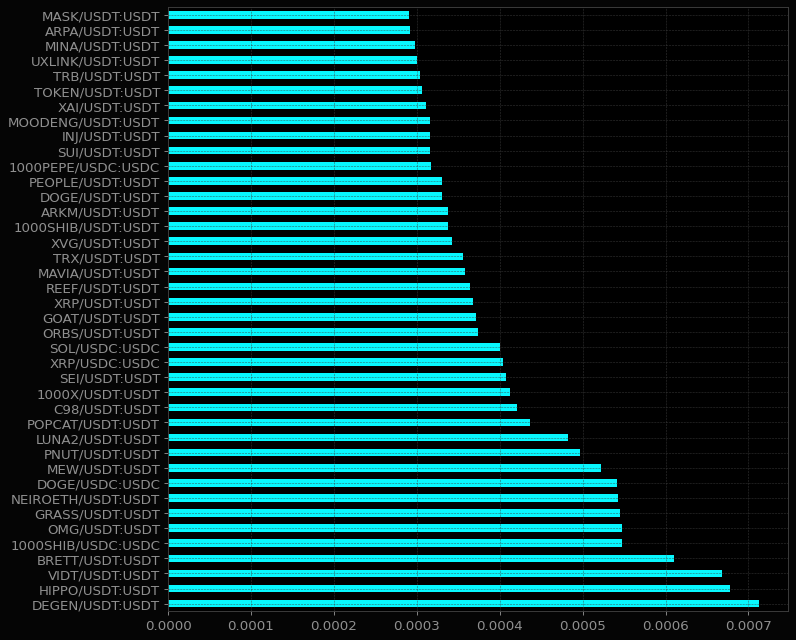

In [60]:
import pandas as pd

df = pd.DataFrame({
    k: v["info"]
    for k, v in mark_prices[-1].items()
}).T
df.sort_values("r", ascending=False).head(40)["r"].astype(float).plot.barh(figsize=(10, 10));

In [8]:
import ccxt.pro as cxp

hpl = cxp.hyperliquid()

In [16]:
hpl.load_markets();

/tmp/ipykernel_3043844/3234204068.py:1: RuntimeWarning: coroutine 'Exchange.load_markets' was never awaited
  hpl.load_markets();


In [23]:
len(hpl.markets)

251

In [24]:
hpl.markets["BTC/USDC:USDC"]

{'id': '0',
 'lowercaseId': None,
 'symbol': 'BTC/USDC:USDC',
 'base': 'BTC',
 'quote': 'USDC',
 'settle': 'USDC',
 'baseId': '0',
 'quoteId': 'USDC',
 'settleId': 'USDC',
 'type': 'swap',
 'spot': False,
 'margin': None,
 'swap': True,
 'future': False,
 'option': False,
 'index': None,
 'active': True,
 'contract': True,
 'linear': True,
 'inverse': False,
 'subType': 'linear',
 'taker': 0.00035,
 'maker': 0.0001,
 'contractSize': 1.0,
 'expiry': None,
 'expiryDatetime': None,
 'strike': None,
 'optionType': None,
 'precision': {'amount': 5,
  'price': 1,
  'cost': None,
  'base': None,
  'quote': None},
 'limits': {'leverage': {'min': None, 'max': 50},
  'amount': {'min': None, 'max': None},
  'price': {'min': None, 'max': None},
  'cost': {'min': 10.0, 'max': None}},
 'marginModes': {'cross': None, 'isolated': None},
 'created': None,
 'info': {'szDecimals': '5',
  'name': 'BTC',
  'maxLeverage': '50',
  'funding': '0.00004212',
  'openInterest': '4761.61398',
  'prevDayPx': '90812

In [27]:
await hpl.fetch_tickers(["BTC/USDC:USDC"])

{'BTC/USDC:USDC': {'symbol': 'BTC/USDC:USDC',
  'timestamp': None,
  'datetime': None,
  'previousClose': 90812.0,
  'close': 89650.5,
  'bid': 89646.7,
  'ask': 89651.0,
  'quoteVolume': 355955270.8665902,
  'info': {'szDecimals': '5',
   'name': 'BTC',
   'maxLeverage': '50',
   'funding': '0.00002453',
   'openInterest': '4762.51512',
   'prevDayPx': '90812.0',
   'dayNtlVlm': '355955270.8665902',
   'premium': '0.00082279',
   'oraclePx': '89573.0',
   'markPx': '89650.0',
   'midPx': '89650.5',
   'impactPxs': ['89646.7', '89651.0'],
   'baseId': 0},
  'bidVolume': None,
  'askVolume': None,
  'high': None,
  'low': None,
  'open': None,
  'last': 89650.5,
  'change': None,
  'percentage': None,
  'average': None,
  'vwap': None,
  'baseVolume': None,
  'indexPrice': None,
  'markPrice': None}}

In [61]:
hpl_markets = await hpl.fetch_swap_markets()

In [64]:
hpl_df = pd.DataFrame(
    {m["symbol"]: m["info"] for m in hpl_markets}
).T.sort_values("openInterest", ascending=False)
hpl_df

,szDecimals,name,maxLeverage,funding,openInterest,prevDayPx,dayNtlVlm,premium,oraclePx,markPx,midPx,impactPxs,baseId,onlyIsolated
BOME/USDC:USDC,0,BOME,5,0.0000639,98597282.0,0.010186,2511247.839163,0.00074108,0.010795,0.010806,0.010809,"[0.010803, 0.01082]",120,NaN
CAKE/USDC:USDC,1,CAKE,10,0.00003142,97037.4,1.9464,162591.38008,0.00046771,1.8815,1.8836,1.88365,"[1.88238, 1.88438]",99,NaN
NOT/USDC:USDC,0,NOT,5,0.0000125,95597852.0,0.007758,1469401.017872,0.00119332,0.007542,0.007548,0.007553,"[0.007551, 0.007555]",132,NaN
TNSR/USDC:USDC,1,TNSR,5,0.0000125,955573.2,0.62309,949449.220355,0.000601,0.599,0.59966,0.5997,"[0.59936, 0.59988]",124,NaN
BIGTIME/USDC:USDC,0,BIGTIME,10,0.00004949,9507774.0,0.16045,515506.14499,0.00122497,0.15184,0.15203,0.152085,"[0.152026, 0.152117]",59,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FRIEND/USDC:USDC,1,FRIEND,3,0.0,0.0,4.72,0.0,None,0.47734,4.72,None,None,43,True
UNIBOT/USDC:USDC,3,UNIBOT,3,0.0,0.0,7.636,0.0,None,6.053,7.636,None,None,35,True
NFTI/USDC:USDC,1,NFTI,3,0.0,0.0,6.6683,0.0,None,2518.4,6.5609,None,None,89,True
RNDR/USDC:USDC,1,RNDR,20,0.0,0.0,6.8946,0.0,None,7.03,6.8952,None,None,20,NaN


In [80]:
hpl_df

,szDecimals,name,maxLeverage,funding,openInterest,prevDayPx,dayNtlVlm,premium,oraclePx,markPx,midPx,impactPxs,baseId,onlyIsolated
BOME/USDC:USDC,0,BOME,5,0.0000639,98597282.0,0.010186,2511247.839163,0.00074108,0.010795,0.010806,0.010809,"[0.010803, 0.01082]",120,NaN
CAKE/USDC:USDC,1,CAKE,10,0.00003142,97037.4,1.9464,162591.38008,0.00046771,1.8815,1.8836,1.88365,"[1.88238, 1.88438]",99,NaN
NOT/USDC:USDC,0,NOT,5,0.0000125,95597852.0,0.007758,1469401.017872,0.00119332,0.007542,0.007548,0.007553,"[0.007551, 0.007555]",132,NaN
TNSR/USDC:USDC,1,TNSR,5,0.0000125,955573.2,0.62309,949449.220355,0.000601,0.599,0.59966,0.5997,"[0.59936, 0.59988]",124,NaN
BIGTIME/USDC:USDC,0,BIGTIME,10,0.00004949,9507774.0,0.16045,515506.14499,0.00122497,0.15184,0.15203,0.152085,"[0.152026, 0.152117]",59,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FRIEND/USDC:USDC,1,FRIEND,3,0.0,0.0,4.72,0.0,None,0.47734,4.72,None,None,43,True
UNIBOT/USDC:USDC,3,UNIBOT,3,0.0,0.0,7.636,0.0,None,6.053,7.636,None,None,35,True
NFTI/USDC:USDC,1,NFTI,3,0.0,0.0,6.6683,0.0,None,2518.4,6.5609,None,None,89,True
RNDR/USDC:USDC,1,RNDR,20,0.0,0.0,6.8946,0.0,None,7.03,6.8952,None,None,20,NaN


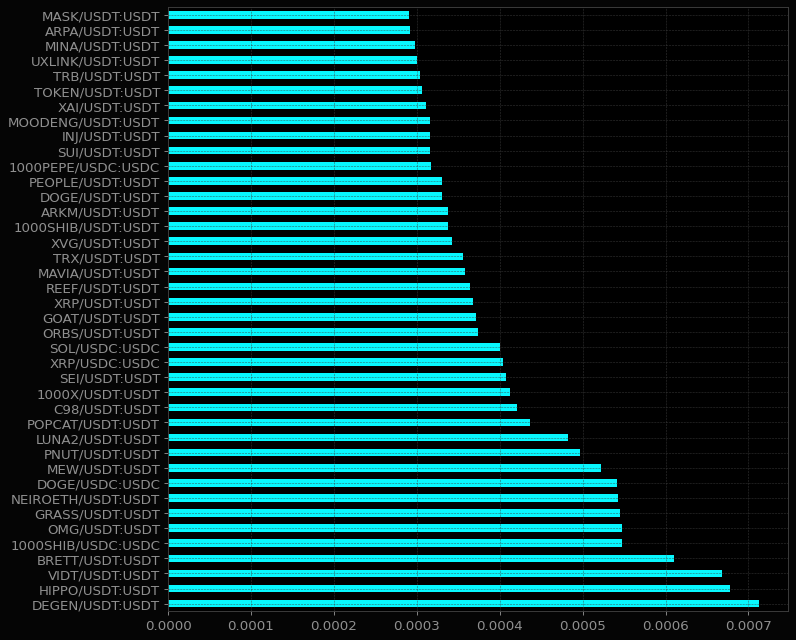

In [85]:
df["r"].rename("binance").astype(float).sort_values(ascending=False).head(40).plot.barh(figsize=(10, 10));

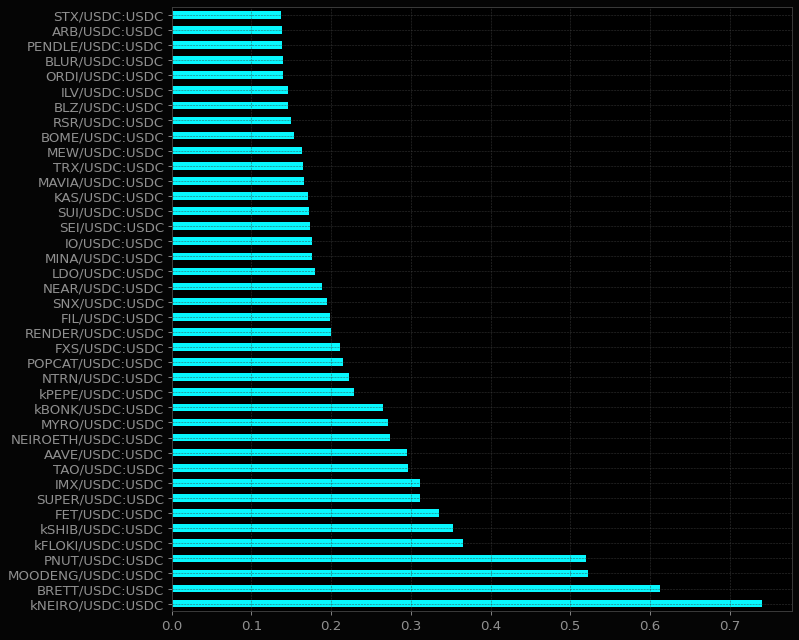

In [90]:
(hpl_df["funding"].astype(float).sort_values(ascending=False).iloc[1:].head(40) * 24 * 100).plot.barh(figsize=(10, 10));

<Axes: >

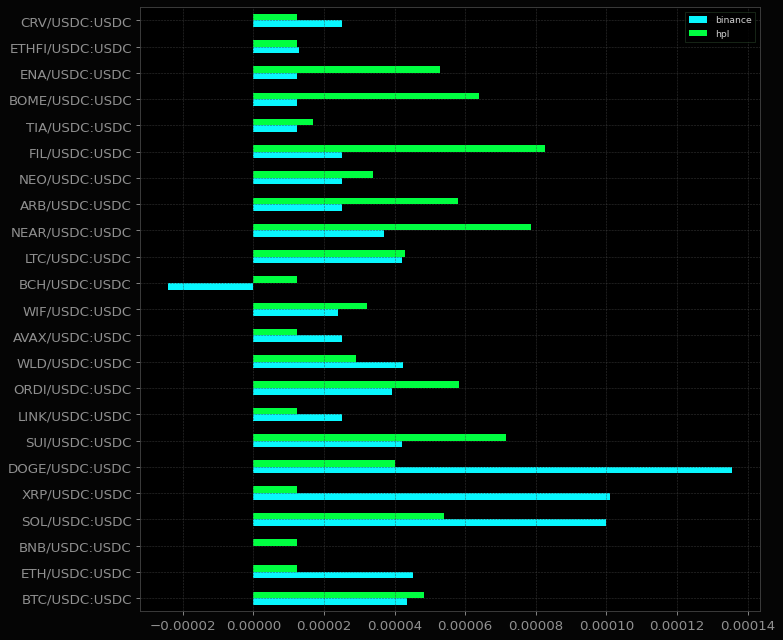

In [83]:
scols(df["r"].rename("binance").astype(float) / 4, hpl_df["funding"].rename("hpl").astype(float)).dropna().astype(
    float
).plot.barh(figsize=(10, 10))